<a href="https://colab.research.google.com/github/vkieuvongngam-ias/learning_tensorflow/blob/master/Recurrent_neuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural net in tensorflow

## Data processing

using authorship attribution problem as an example
first we create a dataframe of text and the author

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
%cd "drive/MyDrive/Colab Notebooks"
print(f"tensorflow version {tf.__version__} and use GPU? {tf.test.is_gpu_available(cuda_only=True)} ")

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks
tensorflow version 2.7.0 and use GPU? True 


In [5]:
train_df = pd.read_csv('spooky-author-identification/train.csv')
train_df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [6]:
g = train_df.groupby('author')
train_resampled = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

train_resampled['author'] = np.where(train_resampled['author'] == 'EAP',0,
                                     np.where(train_resampled['author'] == 'HPL',1,2))
train_resampled = train_resampled[['author','text']]
train_resampled.tail()

author                                               text
author                                                                
MWS    5630       2  Raymond would follow soon, she said; he had be...
       5631       2  Towards evening dark thunder clouds arose abov...
       5632       2  After he had been employed thus about an hour,...
       5633       2  It was in a recess near the head of the ravine...
       5634       2  Shall I meet you again, after having traversed...

## Word tokenization

Here we tokenize the words using our custom tokenization method.

then we pad (from the left side) to 100 word length maximum.

In [7]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
def tokenize_frame(frame1):
    frame = frame1.copy(deep=True)
    frame['tokens'] = frame['text'].apply(lambda x: word_tokenize(x))
    return frame

In [9]:
train_resampled = tokenize_frame(train_resampled)
train_resampled['tokens'] = train_resampled['tokens'].apply(lambda x: [y for y in x if y not in punc])

In [10]:
list_vocab = []
for sentence in train_resampled['tokens']:
  for word in np.unique(sentence):
    list_vocab.append(word)
list_vocab = np.unique(list_vocab)
len(list_vocab)

26232

In [11]:
def create_vocab_dict(vocab):
    dict_str2int = {}
    dict_int2str = {}
    for i,j in enumerate(vocab,1):
        dict_str2int[j] = int(i)
        dict_int2str[i] = j
    return dict_str2int, dict_int2str
dict_str2int, dict_int2str = create_vocab_dict(list_vocab)

In [12]:
def apply_dict(list1):
    result = []
    try:
      for i in list1:
        result.append(dict_str2int[i])
    except:
      for i in list1:
        if i not in dict_str2int.keys():
          print(i,' not in dict')
          dict_str2int[i] = len(dict_str2int.keys())
          result.append(dict_str2int[i])
        else:
          result.append(dict_str2int[i])
    return result
def word2token(frame1):
    frame = frame1.copy(deep=True)
    frame['numeric_tokens'] = frame['tokens'].apply(lambda x: apply_dict(x))
    return frame
def pad_truncate_array(frame,max_len=160,truncate='Post'):
    result = []
    for item in frame['numeric_tokens']:
        if len(item) > max_len:
            if truncate == 'Post':
                result.append(item[:max_len])
            else:
                result.append(item[len(item) - max_len:])
        else:
            result.append([0]*(max_len - len(item)) + item)
    return np.array(result)

def pad_truncate_array(frame,max_len=160,truncate='Post'):
    result = []
    for item in frame['numeric_tokens']:
        if len(item) > max_len:
            if truncate == 'Post':
                result.append(item[:max_len])
            else:
                result.append(item[len(item) - max_len:])
        else:
            result.append([0]*(max_len - len(item)) + item)
    return np.array(result)

In [13]:
train_resampled = word2token(train_resampled)

In [14]:
list_len = []
for i in train_resampled['numeric_tokens']:
  list_len.append(len(i))
np.quantile(list_len, 0.99)  # most text is shorter than 85 tokens.

85.0

In [15]:
train_array = pad_truncate_array(train_resampled,max_len = 100)

In [16]:
train_array

array([[    0,     0,     0, ..., 16341, 14396, 16866],
       [    0,     0,     0, ...,  3790,  4141,  3748],
       [    0,     0,     0, ...,  2495,   174,  5578],
       ...,
       [    0,     0,     0, ..., 23659,  8889, 23926],
       [    0,     0,     0, ..., 22267, 17546,  2256],
       [    0,     0,     0, ...,   286, 17677,   375]])

In [150]:
X_train, X_val, y_train, y_val = train_test_split( train_array, train_resampled['author'].values, 
                                                  test_size=0.1, random_state=42)

In [154]:
X_train.shape

(15214, 100)

In [158]:
y_train = y_train.reshape(-1,1)
y_train.shape

(15214, 1)

# build an LSTM via subclassing

There are 3 ways to build tensorflow model
1. sequential
2. functional API
3. subclassing from layers and models

here we discuss the advantage and disadvantage of each approach.
- the sequential method can't have branch. or multiple inputs and multiple output

- the functional API are more complex, can have branches, and multiple inputs outputs, and shared layers

- model subclassing allows the most customization. essentially we implement our own custom forward-pass of the model similar to pytorch. Eeach layer can be created using a subclass of tensorflow.keras.layers.Layer this comes with it the method "call" which is similar to "forward" in pytorch.

In [159]:
from tensorflow.keras import layers

class Embedding(layers.Layer):
  """ word embedding layer expressed as a subclass of layer"""
  def __init__(self,vocab_size, embedding_dim,**kwargs):
    super(Embedding, self).__init__(**kwargs)
    self.embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)

  def call(self, inputs):
    x = self.embedding(inputs)
    return x

class GRUNet(tf.keras.Model):
  """ combine the custom built layers into an end-to-end model """
  def __init__(self, vocab_size, embedding_dim,**kwargs):
    super(GRUNet,self).__init__(**kwargs)
    #self.hidden_dim = hidden_dim
    #self.n_layers = n_layers
    self.embedding = Embedding(vocab_size=vocab_size, embedding_dim=embedding_dim)
    self.gru = layers.GRU(256,return_sequences=True)
    self.RNN = layers.SimpleRNN(128)
    #self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    #self.accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()
    self.fc = layers.Dense(3, activation="softmax")

  def call(self,inputs):
    embeds = self.embedding(inputs)
    GRU_output = self.gru(embeds)
    RNN_output = self.RNN(GRU_output)
    out = self.fc(RNN_output)
    #loss = self.loss_fn( targets, out)
    #self.add_loss(loss, "loss inside")
    #acc = self.accuracy_fn(targets, out)
    #self.add_metric(acc, name="accuracy")
    return out

Caveat of building via subclassing is that we won't have a static graph like the functional API or sequential method.

therefore we won't be able to see the shape of feature maps until we start running forward pass through the model.

we can still compile and run using the fit method similar to the other two construction methods.

In [160]:
gru_net = GRUNet(vocab_size = len(list_vocab),embedding_dim=300)
# building via subclass method we don't know how layers are connected
# i.e. not a static graph. Hence the summary doesn't work for us

#gru_net.build(input_shape=(None,100))
#gru_net.summary()

In [161]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
gru_net.compile(optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],)
history = gru_net.fit(X_train,y_train, epochs= 5, batch_size = 64,validation_split=0.1)

Epoch 1/5
214/214 [==============================] - 43s 186ms/step - loss: 1.0151 - sparse_categorical_accuracy: 0.4888 - val_loss: 0.8844 - val_sparse_categorical_accuracy: 0.6032
Epoch 2/5
214/214 [==============================] - 39s 182ms/step - loss: 0.6165 - sparse_categorical_accuracy: 0.7596 - val_loss: 0.5641 - val_sparse_categorical_accuracy: 0.7674
Epoch 3/5
214/214 [==============================] - 38s 180ms/step - loss: 0.3183 - sparse_categorical_accuracy: 0.8839 - val_loss: 0.5378 - val_sparse_categorical_accuracy: 0.7779
Epoch 4/5
214/214 [==============================] - 38s 178ms/step - loss: 0.1901 - sparse_categorical_accuracy: 0.9353 - val_loss: 0.5186 - val_sparse_categorical_accuracy: 0.7917
Epoch 5/5
214/214 [==============================] - 37s 175ms/step - loss: 0.1207 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.5749 - val_sparse_categorical_accuracy: 0.7937


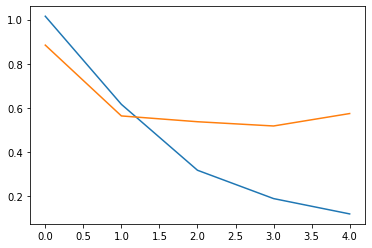

In [162]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

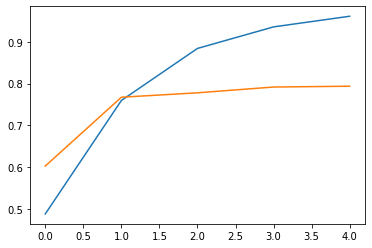

In [163]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])